# Oversampling Techniques for Imbalanced Datasets

In this notebook, we explore various **oversampling techniques** that are commonly used to handle imbalanced datasets, especially in classification tasks. These techniques aim to balance the class distribution by increasing the number of samples in the minority class.

## 1. **Synthetic Minority Oversampling Technique (SMOTE)**
SMOTE is a popular oversampling technique that generates synthetic samples for the minority class by interpolating between existing samples. It helps in creating more diverse samples, reducing overfitting in imbalanced datasets.

## 2. **Adaptive Synthetic Sampling (AdaSyn)**
AdaSyn is an enhancement of SMOTE that focuses on generating more synthetic samples near the decision boundary of the minority class. It prioritizes difficult-to-learn examples, making the classifier's decision boundary more accurate.

## 3. **Random Oversampling (ROS)**
ROS is a simpler technique where samples from the minority class are randomly duplicated until the dataset achieves a more balanced distribution. While easy to implement, this method may lead to overfitting due to the duplication of minority class samples.

---
These techniques are crucial when dealing with imbalanced datasets, as they help improve the model's performance by providing more examples of the minority class.


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv('/home/saumyaryan/Documents/PR/PR_201/Files/creditcard.csv')

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

print('Fraudulent Transactions:', len(fraud))
print('Legitimate Transactions:', len(legit))

Fraudulent Transactions: 492
Legitimate Transactions: 284315


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split


df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])

fraud_train, fraud_test = train_test_split(fraud, test_size=0.3, random_state=42)
legit_train, legit_test = train_test_split(legit, test_size=0.3, random_state=42)

train_data = pd.concat([fraud_train, legit_train])
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Training Data Shape:', train_data.shape)

print('Fraud Data test Shape: ', fraud_test.shape)
print('Legitimate Data test Shape: ', legit_test.shape)

train_data = train_data.values
fraud_test = fraud_test.values
legit_test = legit_test.values

x_train = train_data[:, 1:30]
y_train = train_data[:, 30]


x_fraud_test = fraud_test[:, 1:30]
y_fraud_test = fraud_test[:, 30]

x_legit_test = legit_test[:, 1:30]
y_legit_test = legit_test[:, 30]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_fraud_test = scaler.transform(x_fraud_test)
x_legit_test = scaler.transform(x_legit_test)

print('X_train Shape:', x_train.shape)
print('Y_train Shape:', y_train.shape)
print('X_fraud_test Shape:', x_fraud_test.shape)
print('Y_fraud_test Shape:', y_fraud_test.shape)
print('X_legit_test Shape:', x_legit_test.shape)
print('Y_legit_test Shape:', y_legit_test.shape)

Training Data Shape: (199364, 31)
Fraud Data test Shape:  (148, 31)
Legitimate Data test Shape:  (85295, 31)
X_train Shape: (199364, 29)
Y_train Shape: (199364,)
X_fraud_test Shape: (148, 29)
Y_fraud_test Shape: (148,)
X_legit_test Shape: (85295, 29)
Y_legit_test Shape: (85295,)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from joblib import parallel_backend

def evaluate_model(model, x_train, y_train, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test):
    """
    Evaluates a given model on training and test data.

    Args:
        model: The machine learning model to evaluate.
        x_train, y_train: Training data and labels.
        x_legit_test, y_legit_test: Test data and labels for legitimate transactions.
        x_fraud_test, y_fraud_test: Test data and labels for fraudulent transactions.

    Returns:
        A dictionary containing:
            - Legitimate accuracy
            - Fraud accuracy
    """
    with parallel_backend('loky'):
        # Train the model
        model.fit(x_train, y_train)

    # Evaluate accuracies
    accuracy_legit = model.score(x_legit_test, y_legit_test)
    accuracy_fraud = model.score(x_fraud_test, y_fraud_test)

    return {
        "accuracy_legit": accuracy_legit,
        "accuracy_fraud": accuracy_fraud
    }


models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=4, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
}


In [ ]:
#using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = evaluate_model(model, x_train_smote, y_train_smote, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test)
    print(f"{model_name} Legit Accuracy: {results[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results[model_name]['accuracy_fraud']:.5f}")

Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.94620
Decision Tree Fraud Accuracy: 0.91892
Evaluating SVM...


In [ ]:
print('shape of x_train_rus', x_train_smote.shape)
print('shape of y_train_rus', y_train_smote.shape)

print(results)

shape of x_train_rus (398040, 29)
shape of y_train_rus (398040,)
{'Decision Tree': {'accuracy_legit': 0.9461984876018524, 'accuracy_fraud': 0.918918918918919}, 'SVM': {'accuracy_legit': 0.9843601617914297, 'accuracy_fraud': 0.8851351351351351}, 'Random Forest': {'accuracy_legit': 0.9997537956503898, 'accuracy_fraud': 0.8243243243243243}, 'Logistic Regression': {'accuracy_legit': 0.9741719913242277, 'accuracy_fraud': 0.9324324324324325}, 'AdaBoost': {'accuracy_legit': 0.967758954217715, 'accuracy_fraud': 0.918918918918919}, 'GaussianNB': {'accuracy_legit': 0.9760361099712762, 'accuracy_fraud': 0.8648648648648649}, 'KNN': {'accuracy_legit': 0.9984055337358579, 'accuracy_fraud': 0.8581081081081081}, 'XGBoost': {'accuracy_legit': 0.9993669031010024, 'accuracy_fraud': 0.8581081081081081}}


In [ ]:
# Using AdaSyn
from imblearn.over_sampling import ADASYN

# Apply AdaSyn for oversampling
adasyn = ADASYN(random_state=42)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)

results_adasyn = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results_adasyn[model_name] = evaluate_model(model, x_train_adasyn, y_train_adasyn, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test)
    print(f"{model_name} Legit Accuracy: {results_adasyn[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_adasyn[model_name]['accuracy_fraud']:.5f}")


Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.86322
Decision Tree Fraud Accuracy: 0.95270
Evaluating SVM...
SVM Legit Accuracy: 0.98554
SVM Fraud Accuracy: 0.75676
Evaluating Random Forest...
Random Forest Legit Accuracy: 0.99973
Random Forest Fraud Accuracy: 0.83108
Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.91022
Logistic Regression Fraud Accuracy: 0.94595
Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.91182
AdaBoost Fraud Accuracy: 0.92568
Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.96194
GaussianNB Fraud Accuracy: 0.88514
Evaluating KNN...
KNN Legit Accuracy: 0.99841
KNN Fraud Accuracy: 0.85811
Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:45:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.99927
XGBoost Fraud Accuracy: 0.85135


In [ ]:
results_adasyn

In [ ]:
# Using Random Oversampling (ROS)
from imblearn.over_sampling import RandomOverSampler

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

# Evaluate models on the ROS-balanced dataset
results_ros = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results_ros[model_name] = evaluate_model(model, x_train_ros, y_train_ros, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test)
    print(f"{model_name} Legit Accuracy: {results_ros[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_ros[model_name]['accuracy_fraud']:.5f}")


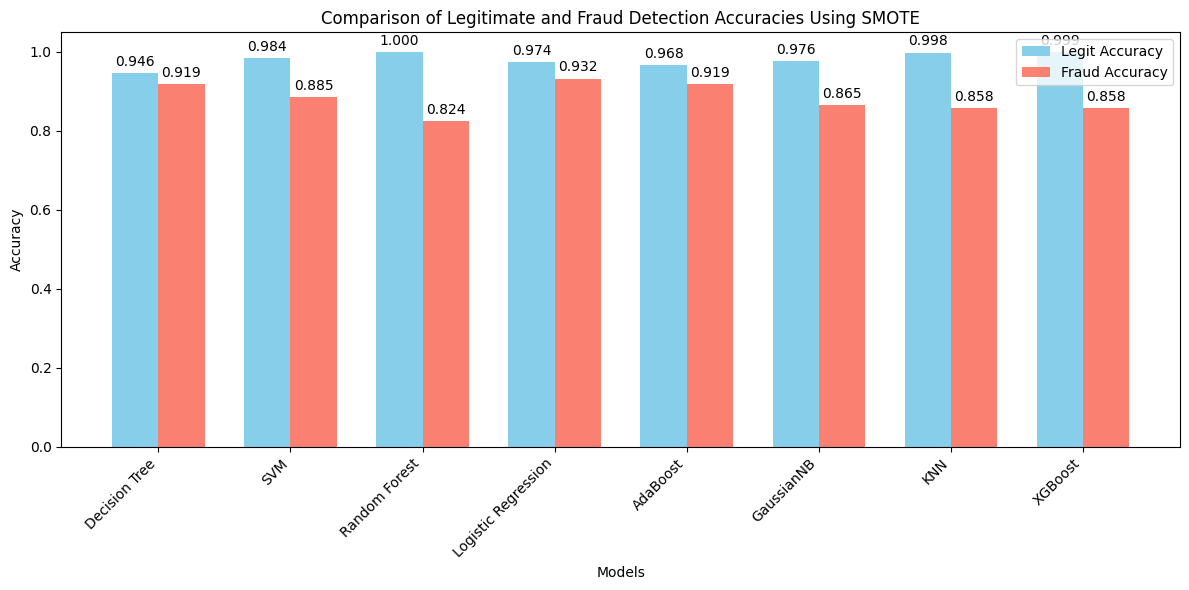

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_adasyn

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using adasyn')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_ros

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using ros')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Example data structure for different techniques (replace with actual results)
results = {
    'SMOTE': results,
    'ADASYN': results_adasyn,
    'ROS': results_ros
}

# Create a list to store the table data
table_data = []

for technique, models in results.items():
    row = {'Technique': technique}
    for model, acc in models.items():
        row[f'{model} (Legit)'] = f"{acc['accuracy_legit']:.5f}"
        row[f'{model} (Fraud)'] = f"{acc['accuracy_fraud']:.5f}"
    table_data.append(row)

# Convert to DataFrame
df_results = pd.DataFrame(table_data)

# Display the table
print(df_results.to_string(index=False))

# Optional: display table nicely in Jupyter Notebook
from IPython.display import display
display(df_results)


NameError: name 'results_rus' is not defined

NameError: name 'results_rus' is not defined